In [91]:
import open_clip
from torchvision import datasets, transforms
import torch
from PIL import Image
import open_clip
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
from sklearn import calibration
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch.nn as nn
import torch.optim as optim
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.isotonic import IsotonicRegression as IR

In [92]:
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
batch_size = 64

In [163]:
def get_preds(model, tokenizer, dset, text_to_append='', temp_scaling=None, divide_by_sum=False):
    text = tokenizer([f'{text_to_append} {x}' for x in dset.classes])
    with torch.no_grad(), torch.cuda.amp.autocast():
        text_features = model.encode_text(text.to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)
    dataloader = DataLoader(dset, batch_size=batch_size, shuffle=False)
    predictions = np.array([])
    actual = np.array([])
    probs = np.array([])
    for image, labels in tqdm(dataloader, total=len(dset) // batch_size):
        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = model.encode_image(image.to(device))
            image_features /= image_features.norm(dim=-1, keepdim=True)
            if temp_scaling is not None:
                image_features = torch.div(image_features, temp_scaling)
            text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            #text_probs = text_probs.norm(dim=-1,keepdim=True)
        vals, indics = text_probs.max(dim=1)
        predictions = np.append(predictions, indics.cpu().numpy())
        actual = np.append(actual, labels.numpy())
        probs = np.append(probs, vals.cpu().numpy())
    return predictions, actual, probs

In [94]:
def calc_bins(y_true, preds, confs, num_bins=10):
  # Assign each prediction to a bin
  bins = np.linspace(1.0 / num_bins, 1, num_bins)
  binned = np.digitize(confs, bins)

  # Save the accuracy, confidence and size of each bin
  bin_accs = np.zeros(num_bins)
  bin_confs = np.zeros(num_bins)
  bin_sizes = np.zeros(num_bins)

  for bin in range(num_bins):
    bin_sizes[bin] = len(preds[binned == bin])
    if bin_sizes[bin] > 0:
      bin_accs[bin] = np.mean(y_true[binned==bin] == preds[binned == bin])
      bin_confs[bin] = np.mean(confs[binned==bin])

  return bins, binned, bin_accs, bin_confs, bin_sizes

In [95]:
def get_metrics(y_true, preds, confs):
  ECE = 0
  MCE = 0
  bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(y_true, preds, confs)

  for i in range(len(bins)):
    abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
    ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
    MCE = max(MCE, abs_conf_dif)

  return ECE, MCE

In [96]:
def draw_reliability_graph(y_true, preds, confs, title=None):
  overall_acc = np.mean(y_true == preds)
  ECE, MCE = get_metrics(y_true, preds, confs)
  bins, _, bin_accs, _, _ = calc_bins(y_true, preds, confs)

  fig = plt.figure(figsize=(8, 8))
  ax = fig.gca()

  # x/y limits
  ax.set_xlim(0, 1.05)
  ax.set_ylim(0, 1)

  # x/y labels
  plt.xlabel('Confidence')
  plt.ylabel('Accuracy')

  # Create grid
  ax.set_axisbelow(True) 
  ax.grid(color='gray', linestyle='dashed')

  # Error bars
  plt.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

  # Draw bars and identity line
  plt.bar(bins, bin_accs, width=0.1, alpha=1, edgecolor='black', color='b')
  plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)

  # Equally spaced axes
  plt.gca().set_aspect('equal', adjustable='box')

  # ECE and MCE legend
  ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
  MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
  acc_patch = mpatches.Patch(color='orange', label='Overall Accuracy = {:.2f}%'.format(overall_acc*100))
  plt.legend(handles=[ECE_patch, MCE_patch, acc_patch])
  if title is not None:
    plt.title(title)

Files already downloaded and verified


157it [00:20,  7.82it/s]                         


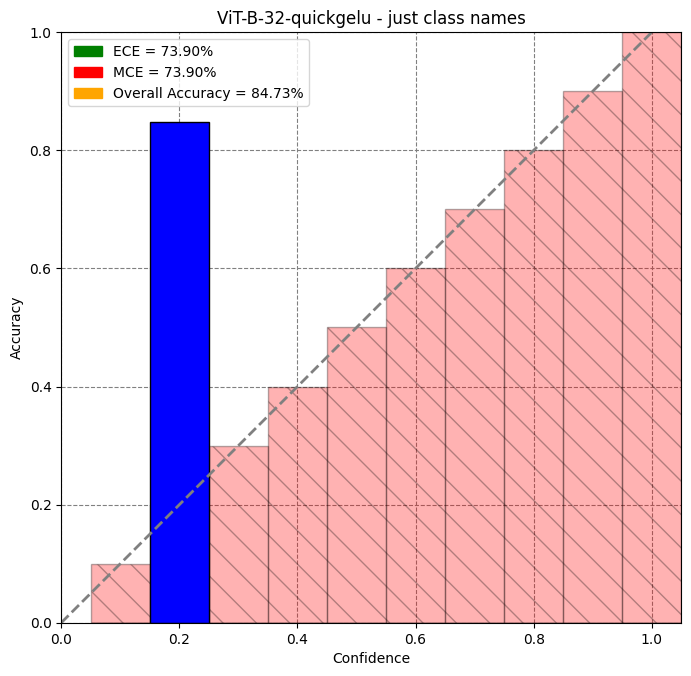

In [162]:
model_name = 'ViT-B-32-quickgelu'
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained='laion400m_e32', device=device)
tokenizer = open_clip.get_tokenizer(model_name)
cifar_test = datasets.CIFAR10('/home/ubuntu/data/', train = False, transform = preprocess, download=True)
predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_to_append='')
draw_reliability_graph(actual, predictions, probs, f"{model_name} - just class names")

Files already downloaded and verified


157it [00:21,  7.37it/s]                         


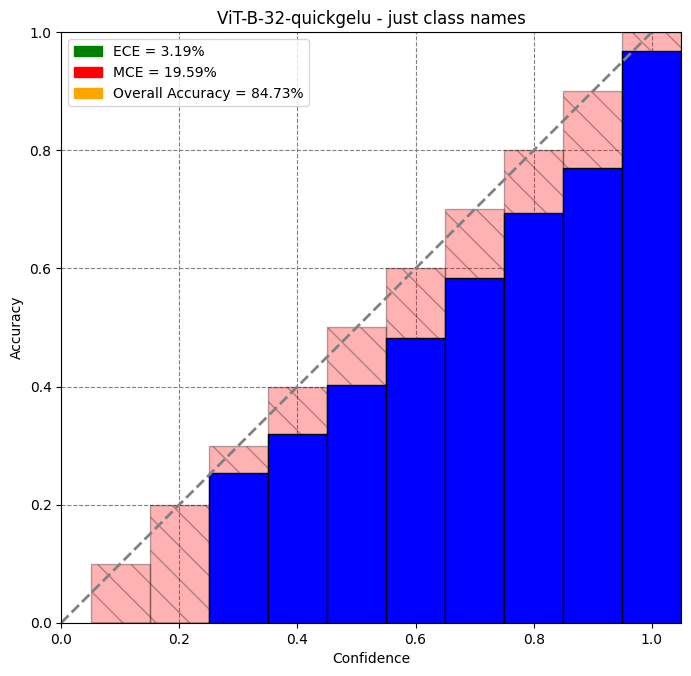

In [97]:
model_name = 'ViT-B-32-quickgelu'
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained='laion400m_e32', device=device)
tokenizer = open_clip.get_tokenizer(model_name)
cifar_test = datasets.CIFAR10('/home/ubuntu/data/', train = False, transform = preprocess, download=True)
predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_to_append='')
draw_reliability_graph(actual, predictions, probs, f"{model_name} - just class names")

Files already downloaded and verified


157it [00:20,  7.49it/s]                         


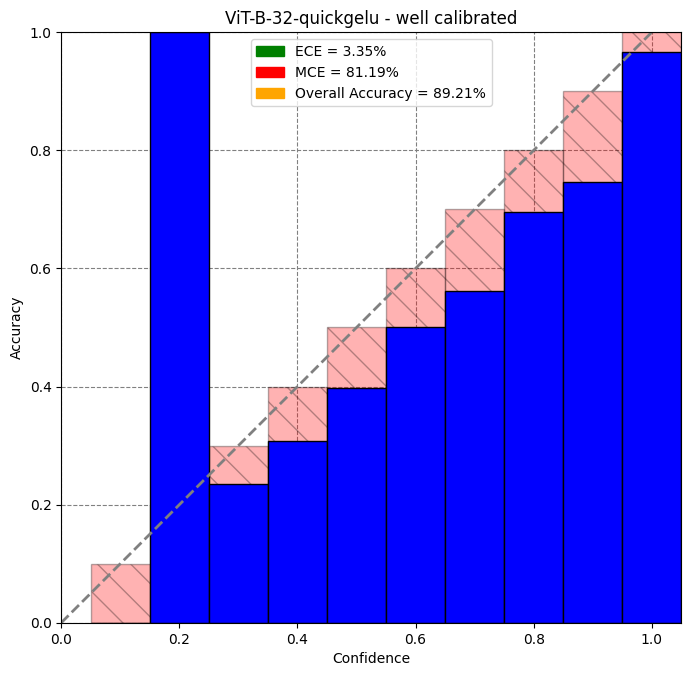

In [109]:
model_name = 'ViT-B-32-quickgelu'
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained='laion400m_e32', device=device)
tokenizer = open_clip.get_tokenizer(model_name)
cifar_test = datasets.CIFAR10('/home/ubuntu/data/', train = False, transform = preprocess, download=True)
predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_to_append='')
draw_reliability_graph(actual, predictions, probs, f"{model_name} - well calibrated")

In [55]:
def T_scaling(logits, args):
  temperature = args.get('temperature', None)
  return torch.div(logits, temperature)

In [56]:
def get_val_set(val_transform):
    cifar_train = datasets.CIFAR10('/home/ubuntu/data/', train = True, transform = val_transform, download=True)
    np.random.seed(0)
    cifar_val = (torch.utils.data.Subset(cifar_train, np.random.randint(0, len(cifar_train), 10000)))
    cifar_val.classes = cifar_train.classes
    return cifar_val
cifar_val = get_val_set(preprocess)

Files already downloaded and verified


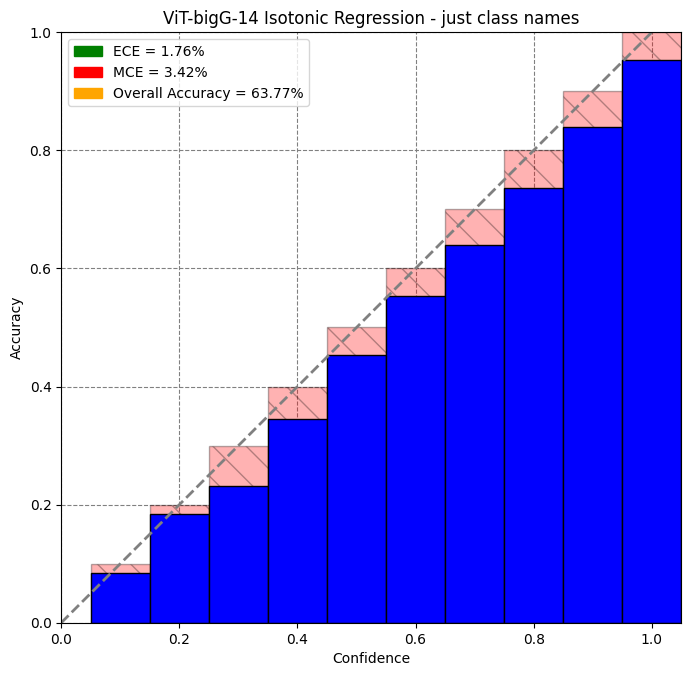

In [58]:
def run_isotonic(y_true, preds, confs):
    ir = IR( out_of_bounds = 'clip' )
    bins, binned, bin_accs, bin_confs, bin_sizes = calc_bins(y_true, preds, confs)
    ir.fit( bin_confs, bin_accs )
    p_calibrated = ir.transform( confs )
    return p_calibrated
calib = run_isotonic(actual, predictions, probs)
draw_reliability_graph(actual, predictions, calib , f"{model_name} Isotonic Regression - just class names")

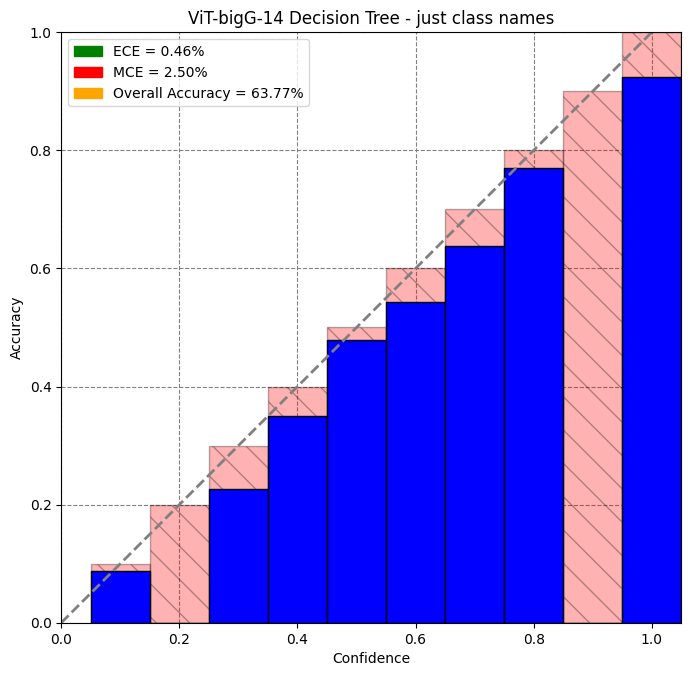

In [59]:
def run_decisiontree(y_true, preds, confs):
    dt = DT()
    bins, binned, bin_accs, bin_confs, bin_sizes = calc_bins(y_true, preds, confs)
    dt.fit( np.expand_dims(bin_confs,1), np.expand_dims(bin_accs,1) )
    p_calibrated = dt.predict( np.expand_dims(confs,1) )
    return p_calibrated
calib = run_decisiontree(actual, predictions, probs)
draw_reliability_graph(actual, predictions, calib , f"{model_name} Decision Tree - just class names")

In [167]:
def find_temp_scale(model, val_dset, show_loss=False, text_to_append='', logits_list=None, labels_list = None):
  temperature = nn.Parameter((torch.ones(1)).to(device))
  args = {'temperature': temperature}
  criterion = nn.CrossEntropyLoss()

  # Removing strong_wolfe line search results in jump after 50 epochs
  optimizer = optim.LBFGS([temperature], lr=0.01, max_iter=70, line_search_fn='strong_wolfe')
  if logits_list is None:
    logits_list = []
    labels_list = []
    temps = []
    losses = []

    text = tokenizer([f'{text_to_append} {x}' for x in val_dset.classes])
    with torch.no_grad(), torch.cuda.amp.autocast():
        text_features = model.encode_text(text.to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)

    val_loader = DataLoader(val_dset, batch_size=batch_size, shuffle=False)
    for i, data in enumerate(tqdm(val_loader, 0)):
        #images, labels = data[0].to(device), data[1].to(device)
        images = data[0].to(device)

        model.eval()
        with torch.no_grad(), torch.cuda.amp.autocast():
          image_features = model.encode_image(images)
          image_features /= image_features.norm(dim=-1, keepdim=True)
          text_probs = (100.0 * image_features @ text_features.T)#.softmax(dim=-1) 
          thresh = torch.mean(text_probs, axis=1) + 1.0 * torch.std(text_probs, axis=1)
          for k in range(len(text_probs)):
            ct = 0
            for j in range(len(text_probs[0])):
              if text_probs[k][j] >= thresh[k]:
                logits_list.append(text_probs[k].unsqueeze(0))
                ct += 1
                #labels_list.append(text_probs.argmax(axis=1)) # text probs: 64,100
                labels_list.append(j)
            #print(ct)
    # Create tensors
    logits_list = torch.cat(logits_list).to(device) # [len(dset), 100]
    labels_list = torch.FloatTensor(labels_list).to(device).long()#torch.cat(labels_list).to(device)

  def _eval():
    loss = criterion(T_scaling(logits_list, args), labels_list)
    loss.backward()
    temps.append(temperature.item())
    losses.append(loss)
    return loss


  optimizer.step(_eval)

  #print('Final T_scaling factor: {:.2f}'.format(temperature.item()))

  if show_loss:
    plt.subplot(121)
    plt.plot(list(range(len(temps))), temps)

    plt.subplot(122)
    plt.plot(list(range(len(losses))), [x.item() for x in losses])
    plt.show()
  return temperature.item(), logits_list, labels_list

100%|██████████| 157/157 [00:24<00:00,  6.36it/s]


torch.Size([12237])
torch.Size([12237, 10])


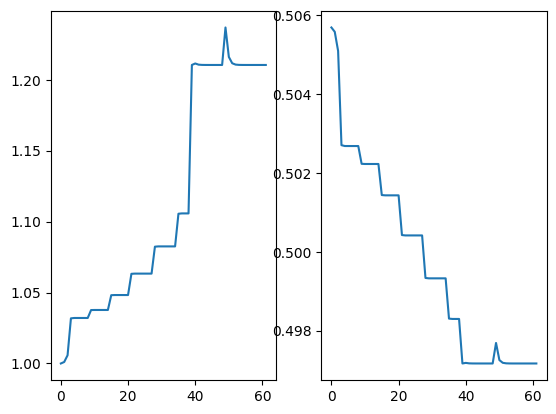

1.210528016090393

In [168]:
scaled_temp = find_temp_scale(model, cifar_val, show_loss=True)
scaled_temp

157it [00:19,  8.07it/s]                         


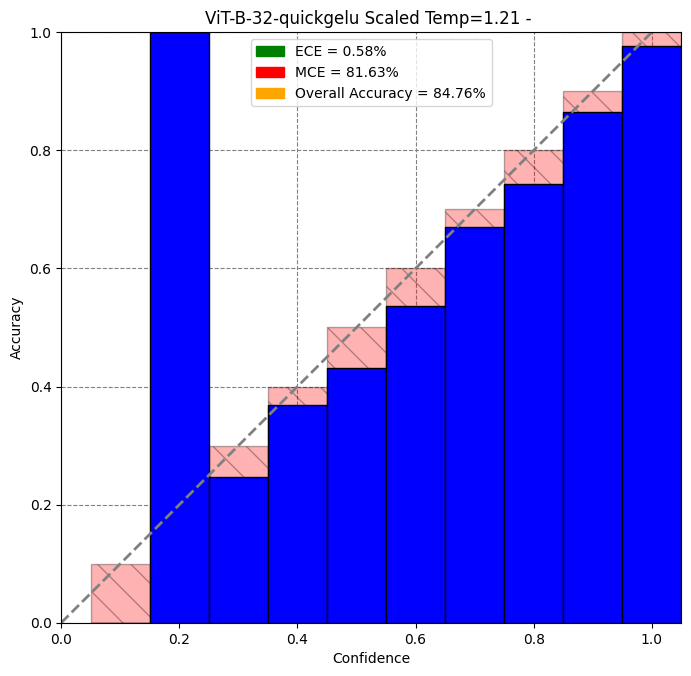

In [169]:
text_to_append = ''
predictions, actual, probs = get_preds(model, tokenizer, cifar_test,  text_to_append=text_to_append, temp_scaling=scaled_temp)
draw_reliability_graph(actual, predictions, probs, f"{model_name} Scaled Temp={scaled_temp:0.2f} - {text_to_append}")

157it [00:20,  7.74it/s]                         
100%|██████████| 157/157 [00:18<00:00,  8.26it/s]
157it [00:21,  7.39it/s]                         


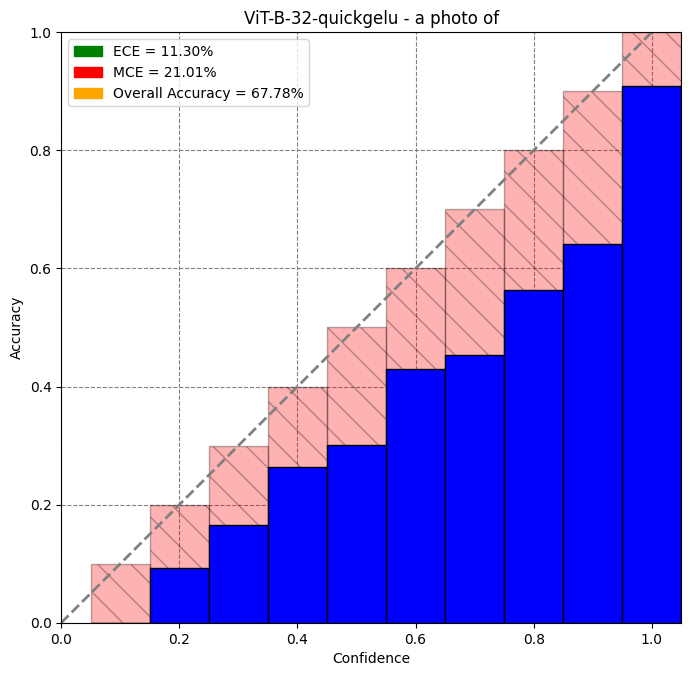

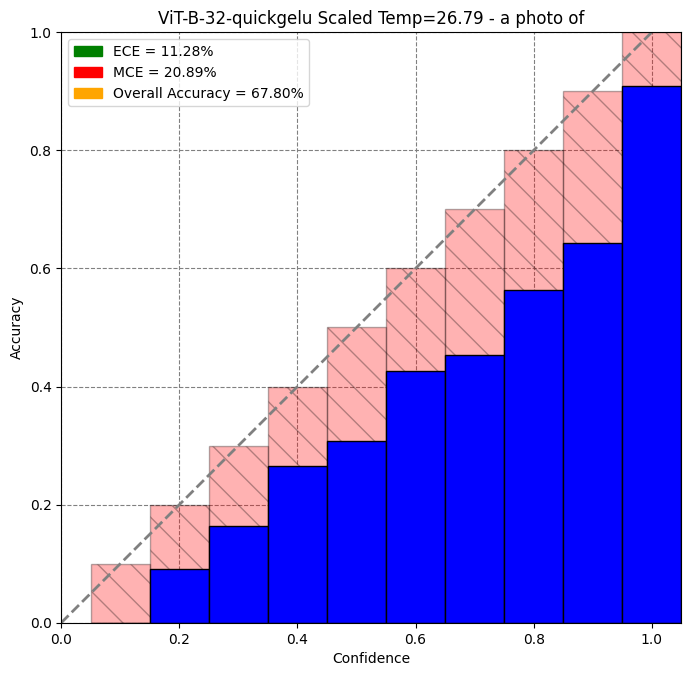

In [36]:
text_to_append = 'a photo of'
predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_to_append=text_to_append)
draw_reliability_graph(actual, predictions, probs, f"{model_name} - {text_to_append}")
scaled_temp = find_temp_scale(model, cifar_val, show_loss=False)
predictions, actual, probs = get_preds(model, tokenizer, cifar_test,  text_to_append=text_to_append, temp_scaling=scaled_temp)
draw_reliability_graph(actual, predictions, probs, f"{model_name} Scaled Temp={scaled_temp:0.2f} - {text_to_append}")

In [57]:
model_name = 'ViT-bigG-14'
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained='laion2b_s39b_b160k', device=device)
tokenizer = open_clip.get_tokenizer(model_name)
cifar_test = datasets.CIFAR100('/home/ubuntu/data/', train = False, transform = preprocess, download=True)


text_to_append = ''
predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_to_append=text_to_append)
draw_reliability_graph(actual, predictions, probs, f"{model_name} - {text_to_append}")
scaled_temp = find_temp_scale(model, cifar_val, show_loss=False)
cifar_val = get_val_set(preprocess)

predictions, actual, probs = get_preds(model, tokenizer, cifar_test,  text_to_append=text_to_append, temp_scaling=scaled_temp)
draw_reliability_graph(actual, predictions, probs, f"{model_name} Scaled Temp={scaled_temp:0.2f} - {text_to_append}")

Files already downloaded and verified


  0%|          | 0/156 [00:01<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 260.00 MiB (GPU 6; 15.78 GiB total capacity; 13.01 GiB already allocated; 222.94 MiB free; 13.72 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [82]:
dataloader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False)

image, _ = next(iter(dataloader))
with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image.to(device))
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    #text_probs /= text_probs.sum()
    print(text_probs)
    text_probs = text_probs.norm(dim=-1,keepdim=True)
    print(text_probs)

In [83]:
text = tokenizer([f'{text_to_append} {x}' for x in cifar_test.classes])
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = model.encode_text(text.to(device))
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [84]:
text_probs.shape

torch.Size([64, 100])

In [86]:
text_probs.norm(dim=-1,keepdim=True).shape

torch.Size([64, 1])

In [87]:
text_probs.norm(dim=-1)

tensor([0.3838, 0.5539, 0.7975, 0.9972, 0.9056, 0.8831, 0.5631, 0.2855, 0.4139,
        0.8719, 0.9232, 0.3682, 0.9072, 0.7587, 0.7935, 0.9925, 0.9866, 0.3520,
        0.9955, 0.8001, 0.9398, 0.9847, 0.3950, 0.5821, 0.9928, 0.5219, 0.9997,
        0.9986, 0.9774, 0.9133, 0.8414, 0.9537, 0.8530, 0.5087, 0.5692, 0.9045,
        0.9997, 0.6829, 0.9788, 0.6877, 0.6399, 0.9272, 0.9734, 0.7224, 1.0000,
        0.5675, 0.8157, 0.9999, 0.2892, 0.4162, 0.7239, 0.9872, 0.9885, 0.9992,
        0.9268, 0.2890, 0.7825, 0.9885, 0.5818, 0.4231, 0.8469, 0.2591, 0.6254,
        0.5007], device='cuda:6')